# Projet PRONTO – Analyse et génération de signaux physiologiques

Ce notebook a été réalisé dans le cadre de l'UE PRONTO à l'IMT Atlantique (site de Nantes) en 2025.  
Il a pour objectif de générer des signaux physiologiques synthétiques réalistes (typiquement : fréquence cardiaque) à partir de données expérimentales, en extrayant puis en restituant les caractéristiques essentielles du signal.

## Équipe projet
- Victor CLAQUIN  
- Adam DENIEULLE  
- Sedki GHARSALLAH  
- Houcine OUSTANI  
**Encadrant** : Monsieur Charles PRUD’HOMME

---

## Objectifs du pipeline
1. **Chargement** et découpage temporel du signal réel.
2. **Détection des R-peaks** pour mesurer les intervalles R-R.
3. **Analyse d’amplitude** des battements via enveloppe.
4. **Extraction de la tendance lente** du signal.
5. **Génération d’un signal synthétique**, battement par battement.
6. **Ajout de bruit** (sur amplitude, largeur, tendance).
7. **Visualisation animée** sous forme de GIF type électrocardiogramme.

> Le code est organisé de manière modulaire, avec des classes dédiées dans des fichiers séparés (`data_loader.py`, `peak_detector.py`, `amplitude_analyzer.py`, `signal_generator.py`, etc.).




## Initialisation du notebook

Cette section configure le notebook pour qu’il puisse accéder aux modules Python définis dans le dossier `scr/`.  
On y importe également toutes les classes nécessaires au traitement des signaux physiologiques :

- `DataLoader` : chargement et découpage des données
- `PeakDetector` : détection des R-peaks
- `AmplitudeAnalyzer` : extraction des enveloppes et hauteurs de battements
- `TrendExtractor` : extraction de la tendance lente
- `SignalGenerator` : génération de signaux synthétiques
- `NoiseInjector` : ajout optionnel de bruit réaliste


In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scr_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'scr'))
if scr_path not in sys.path:
    sys.path.append(scr_path)

# Imports internes
from data_loader import DataLoader
from peak_detector import PeakDetector
from amplitude_analyzer import AmplitudeAnalyzer
from trend_extractor import TrendExtractor
from signal_generator import SignalGenerator
from noise_injector import NoiseInjector

## Chargement des données physiologiques

Dans cette section, nous chargeons les données physiologiques brutes depuis un fichier `.txt` extrait du TP expérimental.  
Le fichier contient plusieurs signaux (pression artérielle, fréquence cardiaque, etc.) mesurés à 200 Hz.

Les paramètres suivants sont définis :
- `filepath` : chemin d'accès au fichier contenant les mesures physiologiques
- `interval_ms` : intervalle d'échantillonnage (ici 5 ms, soit 200 Hz)
- `start_time`, `end_time` : plage temporelle d'analyse (ici de 0 à 250 secondes)

Après chargement, les données sont nettoyées, converties en format numérique, et un affichage graphique des signaux bruts est produit.


Données chargées : 51137 lignes
Durée totale du fichier : 255.68 s
Plage extraite : 0.00 s → 250.00 s


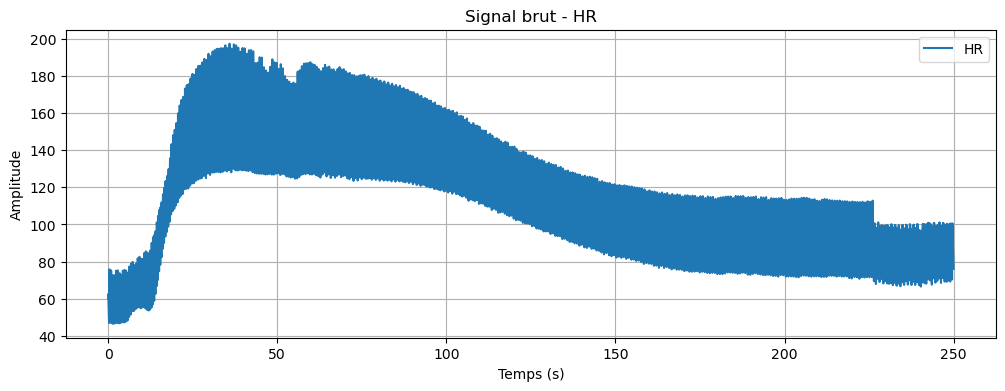

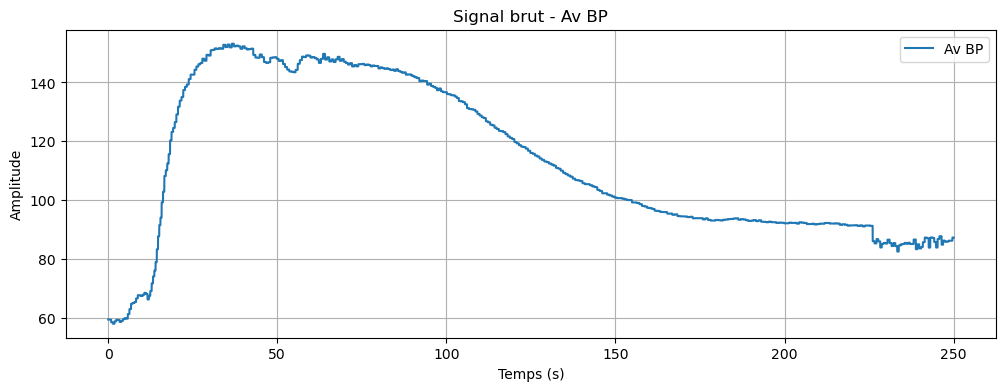

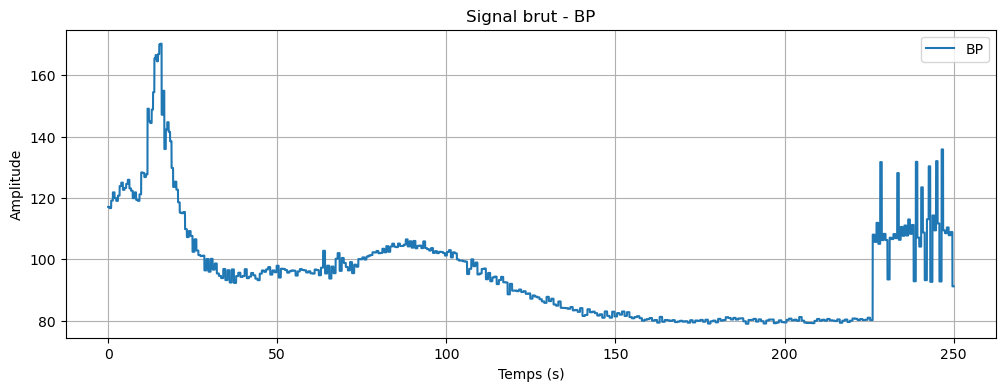

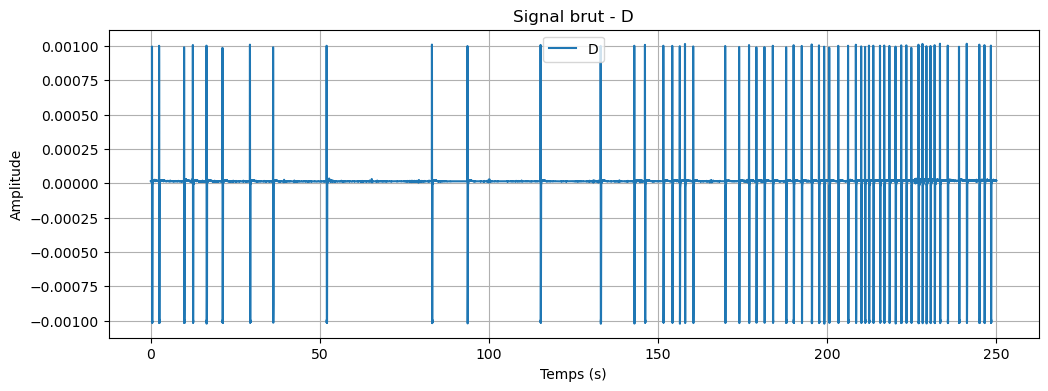

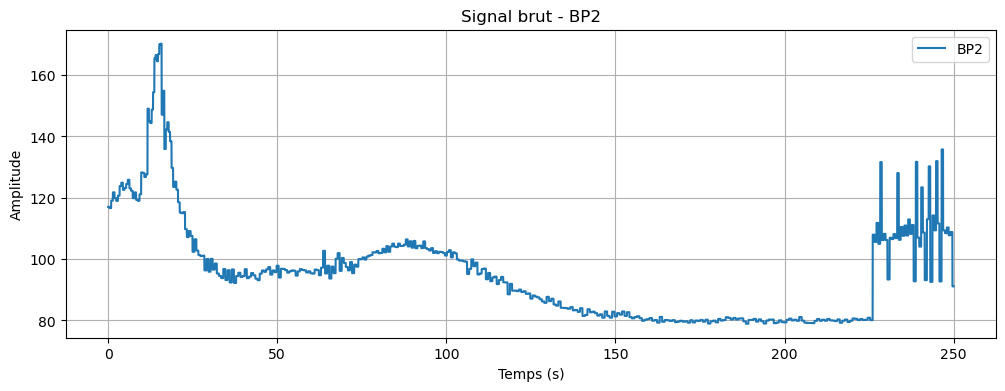

In [2]:

# Paramètres du signal
filepath = "../data/data1/Adrenaline.txt"   
interval_ms = 5
start_time = 0
end_time = 250

sampling_rate = 1000 / interval_ms  # = 200 Hz ici

# Chargement et découpage
loader = DataLoader(filepath, interval_ms)
df_full = loader.load()
df_crop = loader.crop_time_range(start_time, end_time)

# Informations sur les données
total_time = df_full["Time"].max() - df_full["Time"].min()
print(f"Données chargées : {df_full.shape[0]} lignes")
print(f"Durée totale du fichier : {total_time:.2f} s")
print(f"Plage extraite : {df_crop['Time'].min():.2f} s → {df_crop['Time'].max():.2f} s")

# Aperçu des 5 premières lignes extraites
df_crop.head()

# Affichage des signaux bruts
loader.plot(df_crop)



## Détection des R-peaks et analyse des intervalles R-R

Nous détectons ici les R-peaks (pics caractéristiques de l'activité cardiaque) à partir du signal de fréquence cardiaque (`HR`).  
L’algorithme utilisé repose sur la méthode `find_peaks` de SciPy, configurée pour respecter une distance minimale entre battements (`distance_sec`) et une proéminence minimale (`prominence`).

Cette détection permet :
- de localiser les battements cardiaques,
- de calculer les intervalles R-R (temps entre deux battements successifs),
- d’estimer la fréquence cardiaque moyenne.

Les résultats sont affichés sous forme :
- d’un graphe avec les R-peaks superposés au signal global et sur une fenêtre zoomée,
- d’un graphe dédié aux intervalles R-R.


R-R Manual (SciPy) : {'mean_rr_interval_s': 0.6358801020408162, 'std_rr_interval_s': 0.09225659321602074, 'num_beats': 393, 'heart_rate_bpm': 94.35741078771589}


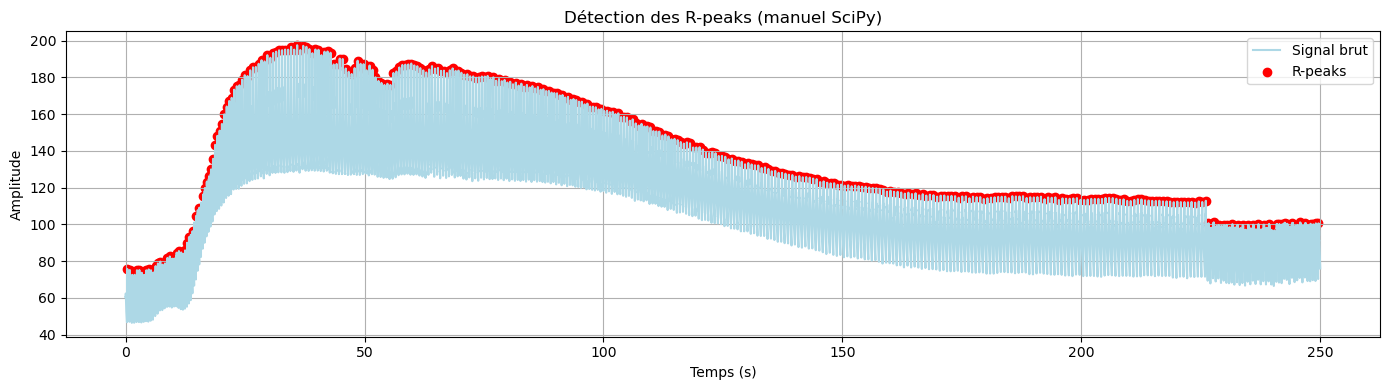

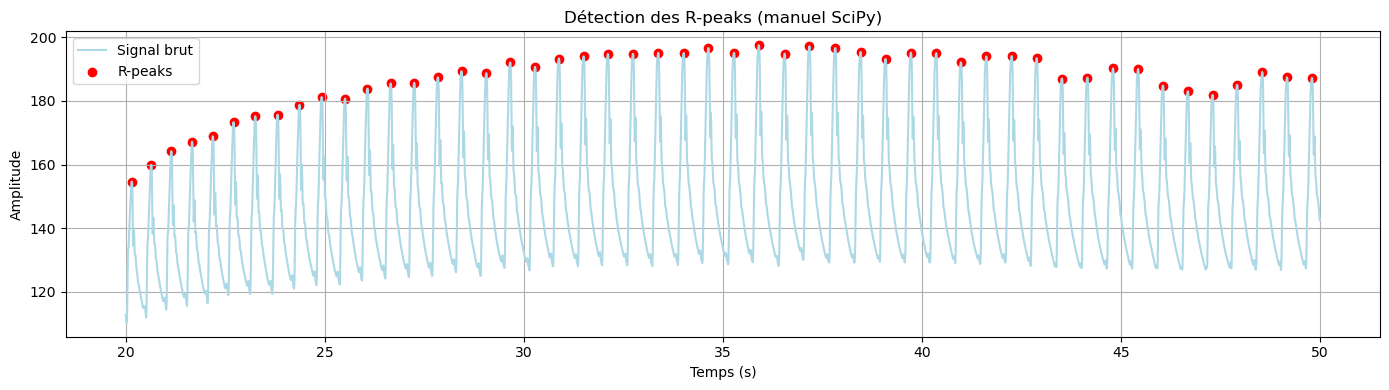

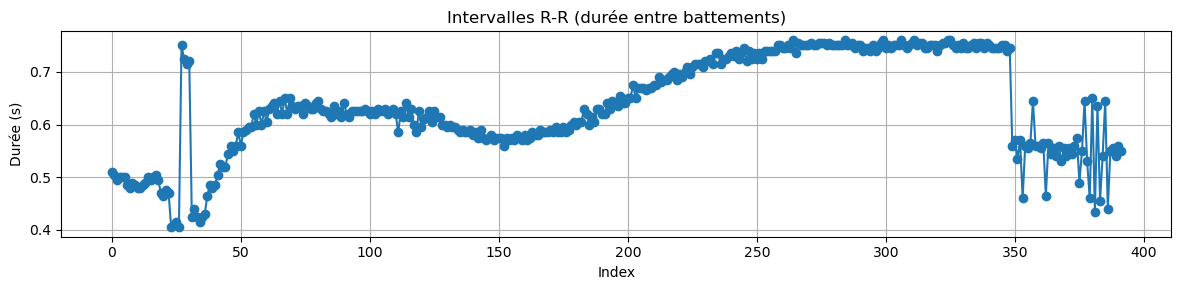

In [3]:
# Paramètres
signal = df_crop["HR"].values
time = df_crop["Time"].values

# Détection manuelle
detector = PeakDetector(signal=signal, time=time, sampling_rate=sampling_rate)
rpeaks, rr_intervals = detector.detect_r_peaks_manual(distance_sec=0.4, prominence=3)

# Statistiques
stats = detector.get_rr_stats()
print("R-R Manual (SciPy) :", stats)

# Affichage global + zoomé
detector.plot_r_peaks()
detector.plot_r_peaks(zoom_start=20, zoom_end=50)

# Graphe des intervalles R-R
detector.plot_rr_intervals()


## Analyse de l’amplitude des battements cardiaques

Ce bloc permet d’estimer l’amplitude des battements cardiaques à partir du signal `HR`, en extrayant une **enveloppe supérieure et inférieure** autour du signal.

Trois méthodes d’extraction sont comparées :
1. **Enveloppe de Hilbert** : basée sur le signal analytique complexe.
2. **Interpolation linéaire des pics max/min** : crée une enveloppe en reliant les sommets détectés.
3. **Fenêtre glissante min/max** : calcule localement les bornes d’amplitude avec un fenêtrage défini.

L’amplitude instantanée est ensuite définie comme la **différence entre l’enveloppe supérieure et inférieure**, et des statistiques globales (moyenne, écart-type, min, max) sont calculées.

Ces informations sont cruciales pour :
- ajuster la hauteur des battements cardiaques dans le signal généré,
- simuler la variabilité naturelle de l’intensité des battements.


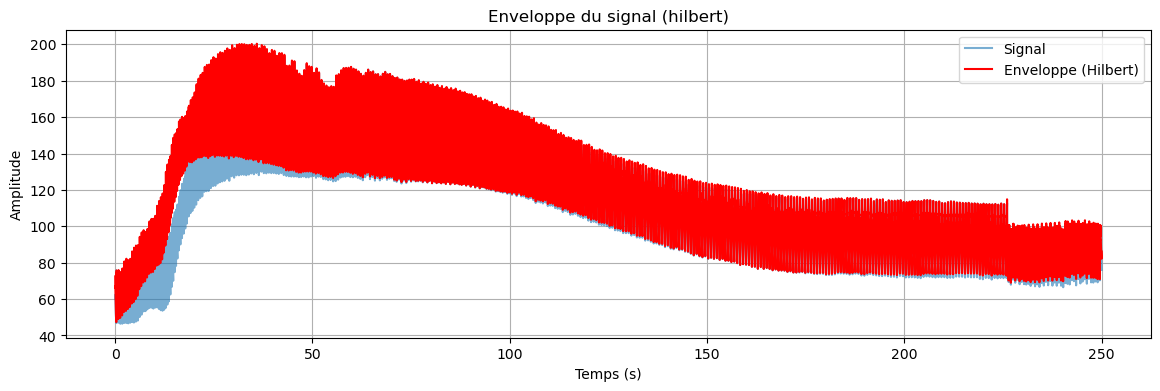

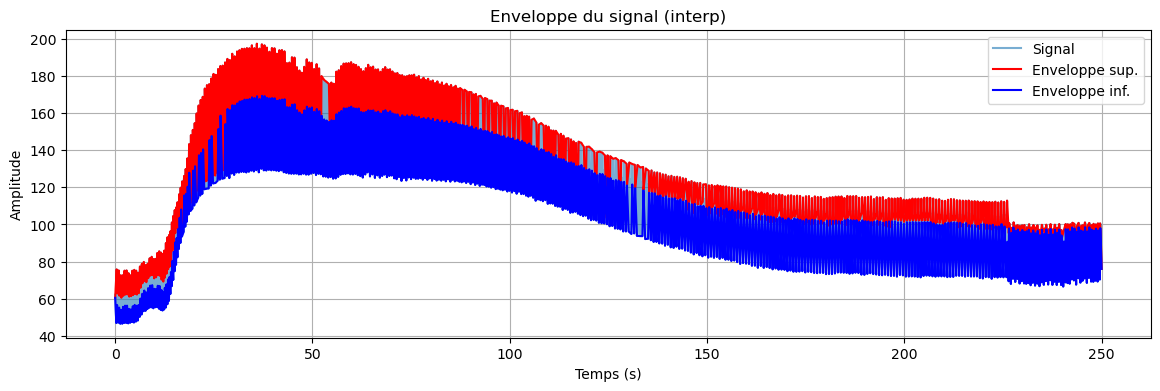

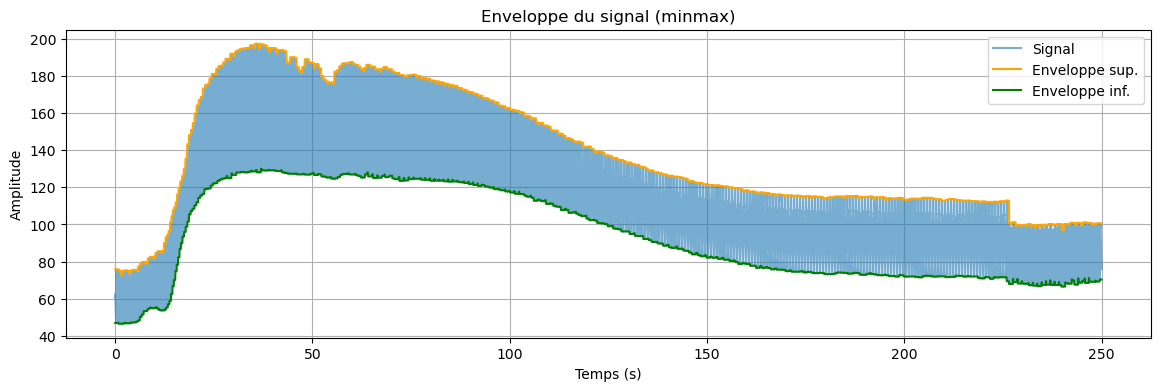

Statistiques d’amplitude (minmax): {'mean_amplitude': 44.30432931341373, 'std_amplitude': 10.165781002392425, 'min_amplitude': 24.440000000000005, 'max_amplitude': 69.37}


In [4]:
# Paramètres
signal = df_crop["HR"].values
time = df_crop["Time"].values

# Analyse d’amplitude avec enveloppes
ampl_analyzer = AmplitudeAnalyzer(signal=signal, time=time, sampling_rate=sampling_rate)

# 1. Enveloppe de Hilbert
ampl_analyzer.compute_hilbert_envelope()
ampl_analyzer.plot_envelope(method="hilbert")

# 2. Enveloppe par interpolation des pics
ampl_analyzer.compute_interpolated_envelope()
ampl_analyzer.plot_envelope(method="interp")

# 3. Enveloppe par min-max glissant
upper, lower = ampl_analyzer.compute_minmax_envelope(window_size=200)
ampl_analyzer.plot_envelope(method="minmax")

# 4. Analyse statistique sur cette enveloppe
amplitudes_array = upper - lower
amplitude_stats = {
    "mean_amplitude": np.mean(amplitudes_array),
    "std_amplitude": np.std(amplitudes_array),
    "min_amplitude": np.min(amplitudes_array),
    "max_amplitude": np.max(amplitudes_array),
}
print("Statistiques d’amplitude (minmax):", amplitude_stats)


## Extraction de la tendance lente du signal

Cette section a pour but de dégager une **tendance globale** du signal de fréquence cardiaque (`HR`), c’est-à-dire son évolution lente au fil du temps. Cette tendance sera utilisée pour moduler le signal généré, afin de reproduire les variations physiologiques de fond.

Trois méthodes sont testées :
1. **Moyenne glissante centrée** : calcule une moyenne locale avec un fenêtrage large, tout en gérant les bords grâce à un **padding miroir**.
2. **Spline cubique lissée** : ajuste une courbe souple aux données, en tenant compte d’un facteur de lissage.
3. **Moyenne des deux méthodes** : permet de combiner les avantages des approches précédentes pour une estimation plus robuste.

Chaque méthode est visualisée pour évaluer sa pertinence sur les signaux bruts.


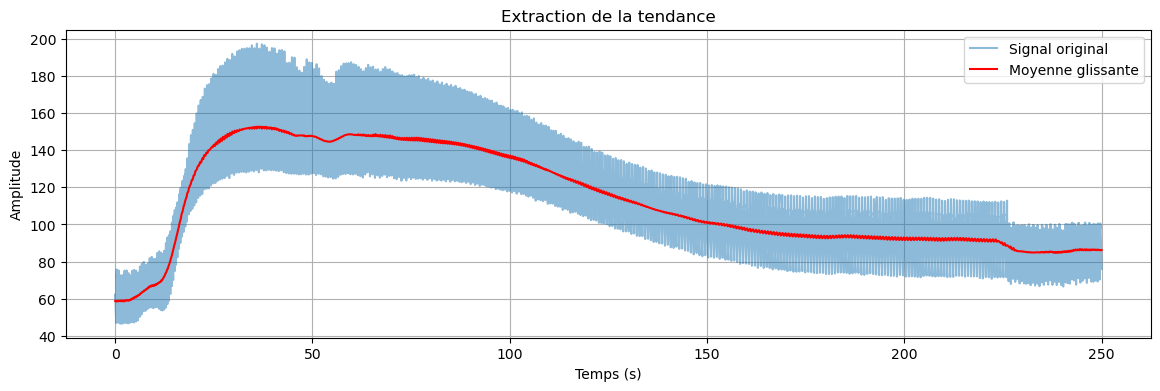

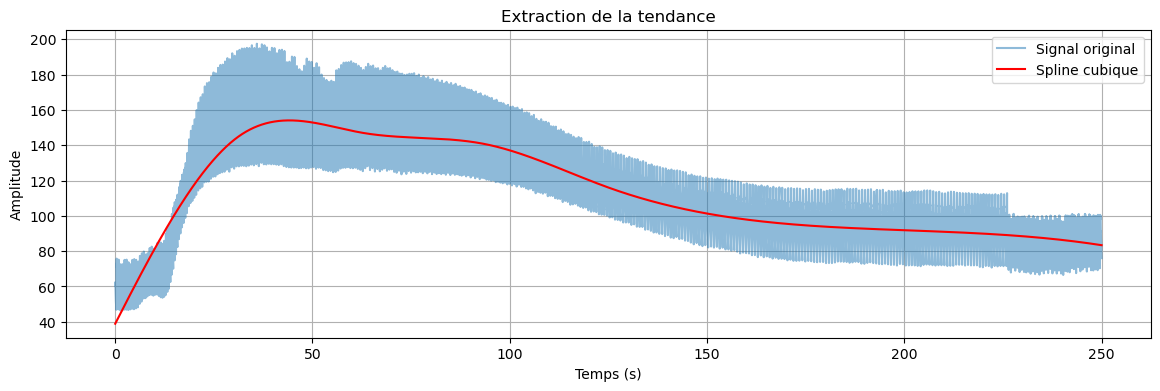

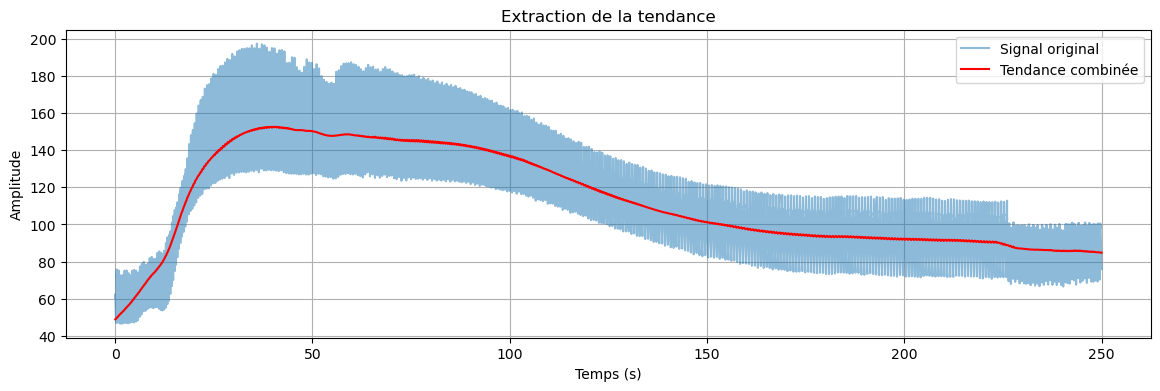

In [5]:

# Initialisation
trend_ex = TrendExtractor(signal=signal, time=time)

# 1 Moyenne glissante avec padding miroir
trend_rolling = trend_ex.extract_rolling_mean(window_size=1001)
trend_ex.plot_trend(label="Moyenne glissante")

# 2️ Spline cubique
trend_spline = trend_ex.extract_spline(smooth_factor=1e7)
trend_ex.plot_trend(label="Spline cubique")

# 3️ Moyenne des deux
trend_combined = trend_ex.extract_combined(rolling_window=1001, smooth_factor=1e7)
trend_ex.plot_trend(label="Tendance combinée")


## Génération du signal synthétique

À partir des informations extraites précédemment (intervalles R-R, amplitude locale et tendance), nous générons un **signal physiologique synthétique** imitant un ECG.

Les étapes sont les suivantes :
1. **Initialisation du générateur** : la classe `SignalGenerator` produit des battements de cœur artificiels à partir de gaussiennes paramétrées.
2. **Détermination des amplitudes** : on extrait l'enveloppe (différence entre les courbes supérieure et inférieure) aux positions des R-peaks.
3. **Ajustement de taille** : on aligne le nombre d’amplitudes sur celui des intervalles R-R détectés.
4. **Génération du signal "plat"** : on aligne les motifs cardiaques battement par battement.
5. **Application de la tendance** : on modifie le signal pour qu’il suive la variation lente observée dans le signal original.
6. **Comparaison visuelle** : on superpose le signal synthétique et le signal réel sur la même plage temporelle pour juger de la fidélité de la reproduction.


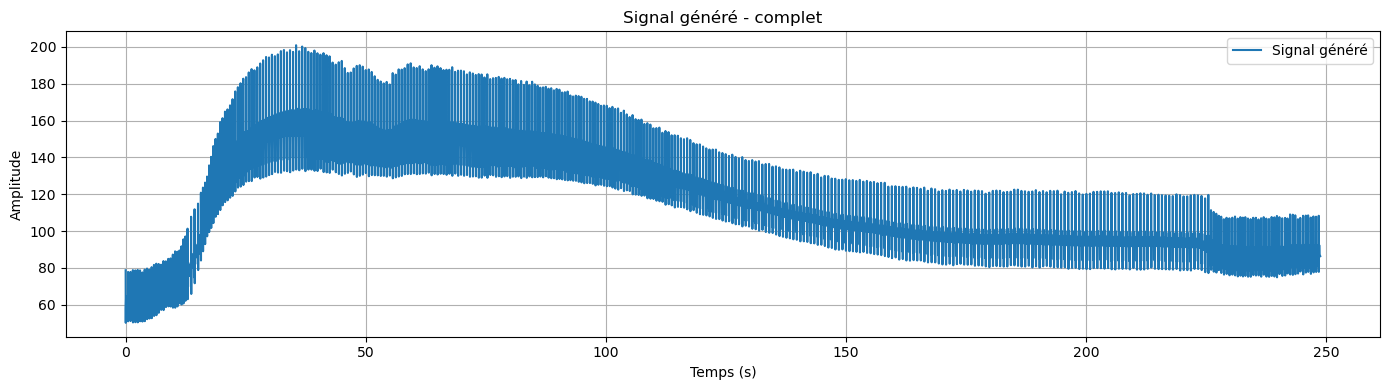

/var/folders/qm/j5wmzzcj5c984rjjdqscj5hh0000gn/T/ipykernel_76930/3989210459.py:51: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


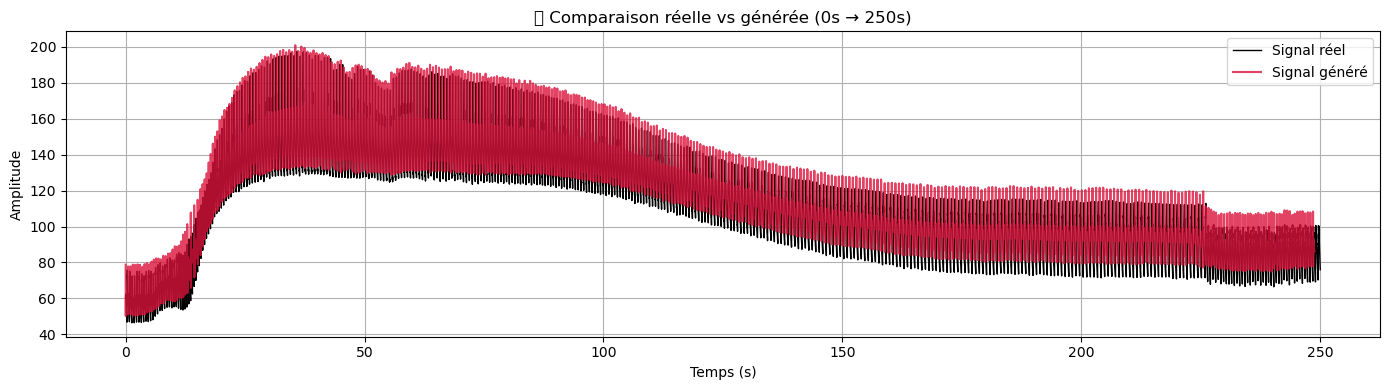

In [6]:
# Génération du signal battement par battement

# Initialisation du générateur
generator = SignalGenerator(sampling_rate=sampling_rate)

# Extraction de l’amplitude locale
amplitudes_array = upper - lower
amplitudes_array = amplitudes_array[rpeaks[:-1]]

# Ajustement taille si nécessaire
if len(amplitudes_array) > len(rr_intervals):
    amplitudes_array = amplitudes_array[:len(rr_intervals)]
elif len(amplitudes_array) < len(rr_intervals):
    rr_intervals = rr_intervals[:len(amplitudes_array)]

# Génération du signal plat
signal_flat = generator.tile_signal_from_arrays(
    rr_intervals=rr_intervals,
    amplitudes=amplitudes_array
)

# Application de la tendance
signal_final = generator.apply_trend(trend_rolling)

# Visualisation du signal généré
generator.plot(title="Signal généré - complet")

# PARAMÈTRES DE ZOOM POUR LA COMPARAISON
zoom_start = start_time
zoom_end = end_time

# Extraction du signal réel dans l’intervalle
mask_real = (df_crop["Time"] >= zoom_start) & (df_crop["Time"] <= zoom_end)
time_real = df_crop["Time"].values[mask_real]
signal_real = df_crop["HR"].values[mask_real]

# Extraction du signal généré dans le même intervalle
mask_gen = (generator.time >= zoom_start) & (generator.time <= zoom_end)
time_gen = generator.time[mask_gen]
signal_gen = signal_final[mask_gen]

# Affichage comparatif
plt.figure(figsize=(14, 4))
plt.plot(time_real, signal_real, label="Signal réel", color="black", linewidth=1)
plt.plot(time_gen, signal_gen, label="Signal généré", color="crimson", alpha=0.8)
plt.title(f"🔍 Comparaison réelle vs générée ({zoom_start}s → {zoom_end}s)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Ajout de bruit réaliste et comparaison finale

Pour simuler un signal physiologique plus proche de la réalité, on injecte du **bruit contrôlé** dans les composantes suivantes :
- **R-R intervals** : fluctuations dans la fréquence cardiaque,
- **Amplitude** : variabilité dans la force des battements,
- **Tendance lente** : dérive globale du signal.

L’objectif est d’obtenir un signal **généré bruité** qui conserve les propriétés globales du signal original tout en y introduisant des **irrégularités naturelles**.

Les étapes sont les suivantes :
1. **Génération du bruit** via la classe `NoiseInjector` avec un `seed` pour la reproductibilité.
2. **Production d’un nouveau signal** à partir des données bruitées.
3. **Visualisation comparative** :
   - Signal réel,
   - Signal généré sans bruit,
   - Signal généré avec bruit.

Cette étape valide la capacité de notre simulateur à imiter des signaux réalistes, tout en offrant une variabilité naturelle utile à des fins de simulation ou d'entraînement algorithmique.


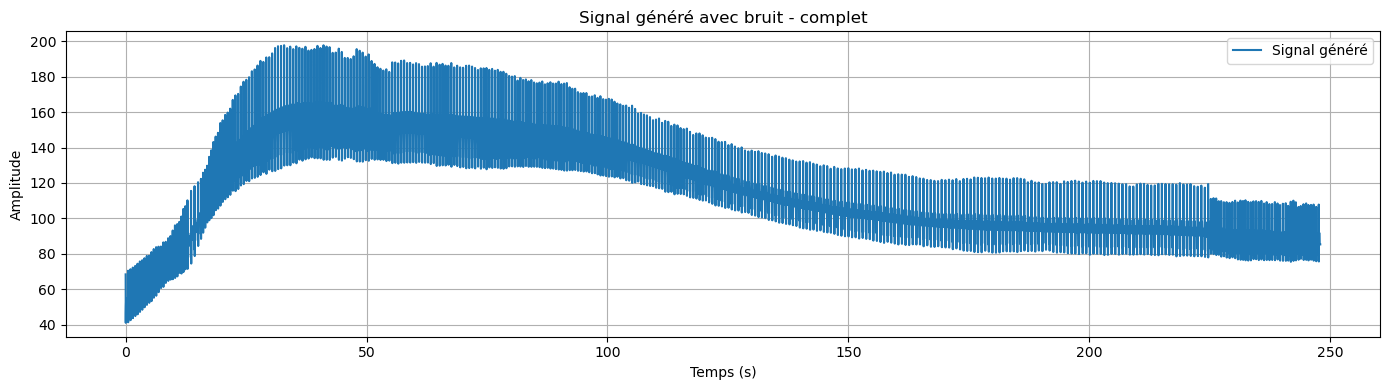

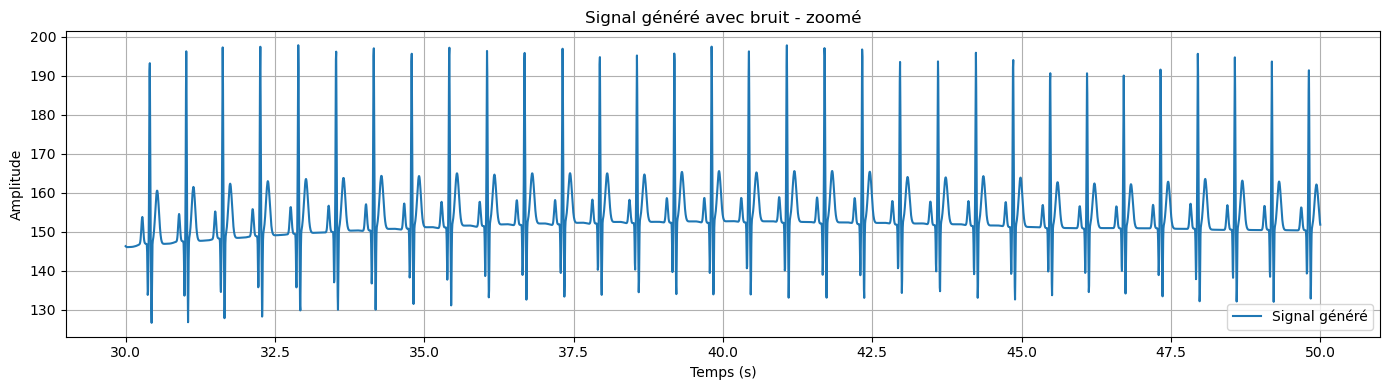

/var/folders/qm/j5wmzzcj5c984rjjdqscj5hh0000gn/T/ipykernel_76930/2655852674.py:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()


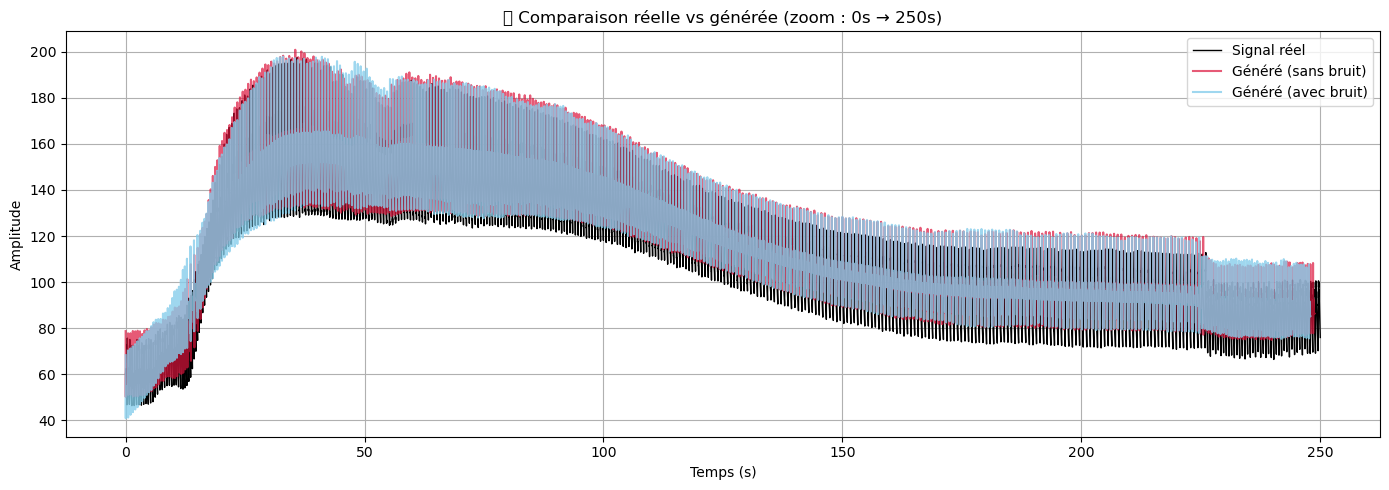

In [7]:
# Injection de bruit
injector = NoiseInjector(seed=42)

rr_intervals_noisy = injector.add_noise_to_rr(rr_intervals, noise_std=0.02)
amplitudes_noisy = injector.add_noise_to_amplitudes(amplitudes_array, noise_std=0.08)
trend_noisy = injector.add_noise_to_trend(trend_combined, noise_std=0.02)

# Génération du signal avec bruit
generator_noisy = SignalGenerator(sampling_rate=sampling_rate)
signal_flat_noisy = generator_noisy.tile_signal_from_arrays(
    rr_intervals=rr_intervals_noisy,
    amplitudes=amplitudes_noisy
)
signal_final_noisy = generator_noisy.apply_trend(trend_noisy)

# Visualisation
generator_noisy.plot(title="Signal généré avec bruit - complet")
generator_noisy.plot(zoom_start=30, zoom_end=50, title="Signal généré avec bruit - zoomé")

# Comparaison réelle vs généré vs bruité sur une plage donnée
zoom_start = start_time
zoom_end = end_time

mask_real = (df_crop["Time"] >= zoom_start) & (df_crop["Time"] <= zoom_end)
time_real = df_crop["Time"].values[mask_real]
signal_real = df_crop["HR"].values[mask_real]

mask_gen = (generator.time >= zoom_start) & (generator.time <= zoom_end)
time_gen = generator.time[mask_gen]
signal_gen = signal_final[mask_gen]

mask_noisy = (generator_noisy.time >= zoom_start) & (generator_noisy.time <= zoom_end)
time_gen_noisy = generator_noisy.time[mask_noisy]
signal_gen_noisy = signal_final_noisy[mask_noisy]

# Affichage superposé
plt.figure(figsize=(14, 5))
plt.plot(time_real, signal_real, label="Signal réel", color="black", linewidth=1)
plt.plot(time_gen, signal_gen, label="Généré (sans bruit)", color="crimson", alpha=0.7)
plt.plot(time_gen_noisy, signal_gen_noisy, label="Généré (avec bruit)", color="skyblue", alpha=0.8)
plt.title(f"🔍 Comparaison réelle vs générée (zoom : {zoom_start}s → {zoom_end}s)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Génération d’un GIF type électrocardiogramme (cardiogramme animé)

Pour rendre la visualisation plus intuitive et dynamique, nous avons créé une animation **type ECG** qui fait défiler le signal généré bruité dans une fenêtre glissante de 5 secondes.

Cette animation est produite à l’aide de la classe `CardioVisualizer`, qui prend en entrée :
- Le signal généré (avec ou sans bruit),
- Le vecteur temporel associé,
- Une fenêtre glissante (en secondes),
- Une plage temporelle ciblée à afficher (ici de 30s à 60s).

Le résultat est sauvegardé sous forme de fichier `.gif` et permet d’illustrer le comportement temporel du signal simulé, dans une perspective proche de celle d’un vrai appareil ECG.

⚠️ À noter : cette animation peut être gourmande en ressources ou parfois instable selon les systèmes ou dépendances Python. Vérifier que le dossier `output/` existe bien, et que les bibliothèques telles que `pillow` sont installées.


In [8]:
from cardio_visualizer import CardioVisualizer

# Exemple : anim sur le segment 30s à 60s
viz = CardioVisualizer(
    signal=signal_final_noisy,
    time=generator.time,
    window_seconds=5,
    start_time=30,
    end_time=60
)

viz.animate("output/cardiogramme_final.gif")
